In [1]:
'''
Code to plot the time resolution or S/N over bias current for different temperature and pixels
Christina Wang
04/06/2025
'''

import awkward as ak
import uproot
import numpy as np
from scipy.optimize import curve_fit


import sys
import datetime
import numpy as np
import pandas as pd
import csv
import os
import subprocess
import ROOT as rt
import itertools
import math


REPO_BASE_PATH = subprocess.Popen(['git', 'rev-parse', '--show-toplevel'], stdout=subprocess.PIPE).communicate()[0].rstrip().decode('utf-8')
plot_path = f"{REPO_BASE_PATH}/plots/ADR/time_resolution_202503/"
os.makedirs(plot_path, exist_ok=True)

sys.path.append(REPO_BASE_PATH + "/lib")
from histo_utilities import *

import tdrstyle
a = tdrstyle.setTDRStyle()

Welcome to JupyROOT 6.30/02


## Open files

In [2]:
files = {}
tree = {}
# Open the input ROOT file
voltages = np.round([ 0.130,0.135,0.140,0.145,0.150,0.155,0.160,0.170,0.180,0.190,0.200,0.210,0.220, 0.230,0.240],3)

biases = [4,1,2] #slot number of voltage source
pixels = [1,2,3] # pixel number in SNSPD
scope_ch = [2,3,4] # channel on scope

inputDirBase = "root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503/"
tempToDir = {
0.2: "20250311_0p2K",
0.5: "20250310_0p5K",
0.8: "20250309_0p8K",
1:"20250310_1p0K",

 }
for k, path in tempToDir.items():
    inputDir = f"{inputDirBase}/{path}/reco/v2/"
    for ch_i, bias_ch in enumerate(biases): # loop over pixels
        name = f"B{bias_ch}_P{pixels[ch_i]}"
        for j, v in enumerate(voltages): # loop over voltages  
            bv_string = str(voltages[j]).replace(".","p")
            files[f'{k}_{name}_{bv_string}'] = inputDir+f'output_run{name}_BV{bv_string}.root'
for k, v in files.items():
    if not os.path.exists(v[v.find("/eos"):]): 
        print("FILE NOT FOUND", v)
        continue
    tree[k] = uproot.open(v)["pulse"]

print(tree.keys())

FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB4_P1_BV0p13.root
FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB4_P1_BV0p135.root
FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB1_P2_BV0p13.root
FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB1_P2_BV0p135.root
FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB2_P3_BV0p13.root
FILE NOT FOUND root://cmseos.fnal.gov///eos/uscms/store/user/christiw/SNSPD_data/ADR_time_resolution_202503//20250311_0p2K/reco/v2/output_runB2_P3_BV0p135.root
FILE NOT FOUND root://cmseos.fnal.gov///eos

## Load relevant branches

In [3]:
time = {}
rise_time = {}
amplitude = {}
time_nofit = {}
time_50mV_nofit = {}
baseline_rms = {}
time_50mV = {}
s2n = {}
intercept = {}
slope = {}
for k, T in tree.items():
    amplitude[k] = T['amplitude'].array()
    rise_time[k] = T['rise_time'].array()
    intercept[k] = T['intercept'].array()
    slope[k] = T['slope'].array()
    
    time[k] = T['time'].array()
    time_nofit[k] = T['time_nofit'].array()
    time_50mV_nofit[k] = T['time_50mV_nofit'].array()
#     time_50mV[k] = T['time_50mV'].array()
    baseline_rms[k] = T['baseline_rms'].array()
    s2n[k] = amplitude[k]/baseline_rms[k]
    
    amp_threshold = 0.5 * np.array([np.mean(amplitude[k][:,0][amplitude[k][:,0]>-999]), np.mean(amplitude[k][:,1][amplitude[k][:,1]>-999])])
    time_50mV[k] = (amp_threshold/amplitude[k] - intercept[k]) / slope[k]
        
        

### Plot the time resolution or S/N vs bias voltage for all pixels on one canvas

In [124]:

for plot_time, fitGaussian in ([0,0,],[0,1],[1,0],[1,1]):
    for fit_func in range(4):
        for temp in tempToDir.keys(): #loop over temperature, one canvas per temperature
    #         if not temp == 0.5:continue
            c = rt.TCanvas("c1","gerrors2",200,10,700,500);
            leg = rt.TLegend(0.25,0.7,0.40,0.85)
            leg.SetTextSize(0.05)
            leg.SetTextFont(42)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)
            leg.SetFillColor(0)
            h = {}
            max_graph = 0
            for ch_i, bias_ch in enumerate(biases): # loop over pixels
                name = f"B{bias_ch}_P{pixels[ch_i]}"
                resolution = []
                resolution_err = []
                bias = []
                sn = []
                for j, v in enumerate(voltages): # loop over voltages  
                    bv_string = str(voltages[j]).replace(".","p")
                    k = f'{temp}_{name}_{bv_string}'
                    if k in tree.keys():
                        ### check if there's too much dark count first ###

                        trg = create_TH1D((time[k][:,0]), axis_title = ['laser time [ns]','Events'], binning = [100,-100,100])
                        if trg.GetBinContent(trg.GetMaximumBin())/trg.Integral()<0.4:
                            print(k, "too much dark count")
                            continue

                        cond = time[k][:,0]>-999
                        if fit_func == 0: var = (time_nofit[k][:,1]-time_nofit[k][:,0])[cond]
                        elif fit_func == 1:var = (time[k][:,1]-time[k][:,0])[cond]
                        elif fit_func == 2:var = (time_50mV[k][:,1]-time_50mV[k][:,0])[cond]
                        else:var = (time_50mV_nofit[k][:,1]-time_50mV_nofit[k][:,0])[cond]
                            
                        peak = np.median(var)
                        hist = create_TH1D(var, binning = [150,peak-3,peak+3])
                        hist.Scale(1./hist.Integral())
                        if fitGaussian:fit, fit_err, _ = fit_gaus(hist, 0.6)
                        else: 
                            emg = EMG()
                            fit, fit_err, _ = fit_emg(hist, emg)

                        resolution.append(fit[2])
                        resolution_err.append(fit_err[2])
                        bias.append(v)
                        sn.append(np.mean(s2n[k][:,1]))
                if plot_time: h[f"p{ch_i+1}_{temp}K"] = create_TGraph(np.array(bias)*100, resolution, ex = np.zeros(len(bias)), ey = resolution_err, axis_title = ['SNSPD current [uA]','Time resolution [ns]'])
                else: h[f"p{ch_i+1}_{temp}K"] = create_TGraph(sn, resolution, ex = np.zeros(len(bias)), ey = resolution_err, axis_title = ['SNSPD S/N','Time resolution [ns]'])
                max_graph = max(max_graph, np.max(resolution))
            for i, k in enumerate(h.keys()):
                h[k].SetLineColor(std_color_list[i])
                h[k].SetMarkerColor(std_color_list[i])
                h[k].SetMarkerSize(0.9)
                h[k].SetMarkerStyle(8)
                h[k].SetTitle('')
                h[k].GetXaxis().SetRangeUser(10,25)
                h[k].GetYaxis().SetRangeUser(0.,0.8)
                h[k].GetYaxis().SetTitleOffset(0.9)
                leg.AddEntry(h[k],k.split('_')[0])
                print(k, max_graph)
                h[k].Draw('PA' if i == 0 else "Psame");


            latex = rt.TLatex()
            latex.SetTextSize(0.05)     
            latex.SetTextFont(42)
            latex.DrawLatex(17, 0.6, f"temperature: {k.split('_')[-1].replace('p','.')}")
            
            leg.Draw()
            c.Draw()
            if fit_func == 0: postfix = "nofit"
            elif fit_func == 1: postfix = "fit_50perc"
            elif fit_func == 2: postfix = "fit_50mV"
            else: postfix = "nofit_50mV"
            if fitGaussian: postfix+= '_gaus'
            else: postfix += '_emg'
            if plot_time:
                c.SaveAs(f'{plot_path}/time_res_{temp}K_{postfix}.png')
                c.SaveAs(f'{plot_path}/time_res_{temp}K_{postfix}.pdf')
            else:
                c.SaveAs(f'{plot_path}/sn_{temp}K_{postfix}.png')
                c.SaveAs(f'{plot_path}/sn_{temp}K_{postfix}.pdf')
            print(f'{plot_path}/sn_{temp}K_{postfix}.pdf')


56.316875 0.035835835835835834 55.76746557216027 58.148239759465774
56.1371875 0.03774151566723396 55.605520243348586 57.90941168883807
55.9809375 0.035556891025641024 55.460009876051 57.71736291316336
55.8325 0.035291758572287946 55.33343157857375 57.49606140475417
55.7309375 0.03691376701966717 55.229661717519264 57.40185677493581
55.5590625 0.03651282051282051 55.06062654210149 57.22051569299505
55.44187498509884 0.03562019180103278 54.929342646484166 57.15031611381443
55.3246875 0.03404901322923444 54.81291922662418 57.03058174458608
55.23875 0.03494653290706648 54.72502207047052 56.95117643176495
54.816250000000004 0.03579443447037702 54.29703367953598 56.546971068213416
54.745937500000004 0.03724373576309795 54.22637709426208 56.47780551912642
55.0590625 0.03739191399859781 54.533527447724154 56.81084600758616
54.948750000000004 0.0327027027027027 54.395825609730664 56.7918313008978
52.316875 0.035546210073095025 51.732680554967175 54.2641898167761
52.145 0.03293293293293294 51.5

51.8090625 0.032888799759350246 51.27090396975012 53.6029242674996
51.67625 0.03497278774440637 51.14269300561864 53.45477331460456
51.473125 0.03734535784483755 50.924642815874606 53.301398947084664
1_B1_P2_0p18 too much dark count
1_B1_P2_0p19 too much dark count
57.4653125 0.031628465619057154 56.8904288759689 59.38159124677035
57.3090625 0.03563920312343578 56.73963549523802 59.20715251587328
57.160625 0.034638101912103314 56.6110987747239 58.992379084253685
56.98875 0.033543606688695306 56.453035304335735 58.77446565221423
56.879375 0.03765816429001807 56.35625439371228 58.623110354292415
56.7621875 0.04045079492855705 56.24534703783759 58.48498904054138
56.61375 0.03858356360659093 56.100831139413074 58.323479535289756
56.4965625 0.03893486102270316 55.9753707120064 58.23386845997869
56.36375 0.034885228893788096 55.81003991253673 58.20945029154424
p1_1K 0.465246040557834
p2_1K 0.465246040557834
p3_1K 0.465246040557834
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plot

p1_0.8K 0.2708302293607094
p2_0.8K 0.2708302293607094
p3_0.8K 0.2708302293607094
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.8K_fit_50perc_emg.pdf
56.16156777985007 0.036325427799459624 55.63966455955543 57.901245180832206
56.020357233127626 0.03982787951566096 55.51928852757712 57.690586251629334
55.75931009839086 0.04366112557580613 55.277277460900315 57.36608555669268
55.75597423040662 0.04770495089196232 55.292511815636594 57.30084894630672
55.64256422970855 0.0503922751961376 55.201679738965524 57.112179198851955
55.53695029668306 0.053515427415275665 55.09482277664646 57.010708696805054
55.37596479058017 0.05370658372213582 54.931787515181895 56.85655570857442
55.217101584794314 0.05529639321879622 54.76259536154699 56.732122328952045
1_B4_P1_0p19 too much dark count
52.218049223935175 0.03647294589178357 51.704659743495384 53.92934749206781
51.90741844316762 0.03762633843690583 51.39015042439078 53.63164517242375
51.94238065437

55.76713992621809 0.05003502451716201 55.31930498404423 57.25992306679763
55.59388506867939 0.05494285141367555 55.17176116191841 57.00096475788266
55.530137626637824 0.0556618017111223 55.1116170785983 56.925206120102914
55.4289523792783 0.05814546567377333 55.00744397323205 56.83398039943246
55.34714101378376 0.06120743680802172 54.927776849297906 56.745021562069944
55.17608053354171 0.06247997436719 54.75722350847459 56.572270617098766
55.06359141042349 0.05934685906477162 54.64158836977955 56.47026821256996
55.120719321785735 0.05801613131456064 54.63207183790052 56.749544268069776
0.8_B4_P1_0p22 too much dark count
52.10546269101308 0.036925848093665566 51.59514494676962 53.806521838491264
51.87271020156942 0.03831532613045218 51.37476671284017 53.53252183066691
51.75064020513924 0.047051756932625886 51.26456536102267 53.37088968552781
51.645403049687324 0.04614152737463717 51.179931991577234 53.196973243387625
51.51695763748649 0.048034496590453266 51.08042722871536 52.9720590000

56.9028125 0.036046860919194956 56.35112516905261 58.741770269824656
56.5746875 0.037964539717519785 56.02715685972264 58.399789634257885
56.3715625 0.04059743384121892 55.83517922187111 58.15950676042965
55.9340625 0.03499340703925347 55.36086510889156 57.84472047036147
55.900625000000005 0.03292607165044523 55.29184170644194 57.929902645193536
55.715 0.0314927119906373 55.05849497092451 57.90335009691833
55.5665625 0.035562343187520454 54.87233871938043 57.88064176873192
55.49125 0.029088486732541358 54.724284240950006 58.047802530166656
55.29500001490116 0.028165840468679586 54.48133919523169 58.00720274713275
p1_0.5K 0.5213156898332506
p2_0.5K 0.5213156898332506
p3_0.5K 0.5213156898332506
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.5K_nofit_50mV_emg.pdf
56.73015625 0.03577871316897174 56.17817359085001 58.57009844716665
56.598125 0.03423766142757033 56.04688105332413 58.43560482225292
56.3246875 0.037826478534974485 55.78958194157

0.2_B1_P2_0p22 too much dark count
0.2_B1_P2_0p23 too much dark count
0.2_B1_P2_0p24 too much dark count
p1_0.2K 2.1875574165502356
p2_0.2K 2.1875574165502356
p3_0.2K 2.1875574165502356
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.2K_nofit_50mV_gaus.pdf
0.5_B1_P2_0p22 too much dark count
p1_0.5K 2.1874745821271353
p2_0.5K 2.1874745821271353
p3_0.5K 2.1874745821271353
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.5K_nofit_50mV_gaus.pdf
0.8_B4_P1_0p22 too much dark count
0.8_B1_P2_0p2 too much dark count
0.8_B1_P2_0p21 too much dark count
0.8_B1_P2_0p22 too much dark count
p1_0.8K 1.1163570148463107
p2_0.8K 1.1163570148463107
p3_0.8K 1.1163570148463107
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.8K_nofit_50mV_gaus.pdf
1_B4_P1_0p19 too much dark count
1_B1_P2_0p18 too much dark count
1_B1_P2_0p19 too much dark count
p1_1K 2.19086740340700

56.4221875 0.037118383483417526 55.90648444820925 58.14119767263584
56.17625 0.03632249612957009 55.63845315086406 57.96890616378649
p1_0.8K 0.3893290227793875
p2_0.8K 0.3893290227793875
p3_0.8K 0.3893290227793875
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.8K_nofit_emg.pdf
56.3403125 0.03482786228983186 55.805534946487896 58.122904345040354
56.191875 0.03943943943943944 55.67440609525568 57.916771349147766
56.066875 0.040348418101722065 55.55182077149625 57.78372242834584
55.895 0.039390598376265414 55.394690806772225 57.56269731075926
55.7934375 0.03640752288041838 55.3075848414143 57.412946361952365
55.6840625 0.038846737481031866 55.19123898612304 57.326807546256546
55.5590625 0.035054967848993986 55.06180641111324 57.216582796289224
55.4340625 0.0362953692115144 54.92532467045261 57.12985526515799
1_B4_P1_0p19 too much dark count
52.4028125 0.038272718164512574 51.82759423951192 54.32020670162696
52.27 0.03473125813231909 51.6862

55.05285460149567 0.06519587045679535 54.56399634450261 56.68238212480584
0.8_B4_P1_0p22 too much dark count
52.098650979792936 0.03853853853853854 51.60412880999097 53.74705821246616
51.861975798384115 0.04231692677070829 51.379022527373486 53.47182003508622
51.82231725036183 0.04464464464464465 51.34470948270601 53.41434314254789
51.6445131484468 0.047132993095166616 51.18851776235069 53.16449776876716
51.46783090738355 0.05334937825912555 51.03825496246869 52.89975072376642
51.36457770822478 0.05663430420711974 50.94444115994997 52.76503286914081
51.19480271317262 0.05964296770199154 50.7586358210236 52.648692353669354
51.124136303073904 0.05907797381900968 50.66681933610127 52.648526192982686
0.8_B1_P2_0p2 too much dark count
0.8_B1_P2_0p21 too much dark count
0.8_B1_P2_0p22 too much dark count
57.23874348022514 0.03764140554610071 56.74540979382941 58.88318910154423
57.00421751927867 0.04433990591532379 56.52424890262353 58.60411290812911
56.794239742313486 0.04363054137896528 56.

51.07054466015169 0.04853603603603604 50.60721175672625 52.61498767156982
0.5_B1_P2_0p22 too much dark count
57.21408814743419 0.03482437706394476 56.69427952949041 58.946783540580135
57.00728065984335 0.03833450105094585 56.50009915819651 58.69788566533282
56.83502538180209 0.03964360796876564 56.34657890296657 58.46318031125382
56.73704238547919 0.045085662759242556 56.26086266099349 58.32430813376487
56.59293107096837 0.04792460397032284 56.140022710419814 58.10262560613021
56.44133306367147 0.048980833586857314 55.98651594355855 57.957390130714536
56.39541692088101 0.05114401076716016 55.95159350775047 57.87482829798283
56.34494040935605 0.05126023609486334 55.88770162603575 57.86906968709038
56.06876443417549 0.05012531328320802 55.62113788685274 57.560852925251325
56.23753512766657 0.04856952761144378 55.7753799584629 57.77805235834548
56.14435110334619 0.04732464028776979 55.673082133141946 57.715247670693664
p1_0.5K 0.2929653156656075
p2_0.5K 0.2929653156656075
p3_0.5K 0.292965

p1_0.2K 0.5682363874433672
p2_0.2K 0.5682363874433672
p3_0.2K 0.5682363874433672
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.2K_nofit_50mV_emg.pdf
56.3403125 0.03354024829795755 55.79799862921578 58.148025402614074
56.066875 0.03173173173173173 55.520582633159506 57.88784955613498
55.7778125 0.0333466853595033 55.2504251727908 57.535770257364014
55.360937500000006 0.035029609555354814 54.847426304442635 57.07264148519125
55.27 0.03988317051062544 54.765224367862785 56.95258544045739
54.910625 0.03883892068683565 54.41387611431602 56.56645461894662
54.629375 0.03664537744738771 54.1140977049441 56.34696598351968
54.395 0.03958802703572578 53.85838962446542 56.18370125178195
54.1684375 0.034156015866020274 53.5996788530214 56.06429965659534
54.3165625 0.03439447907390917 53.70533206101913 56.35399729660293
53.9575 0.0335593220338983 53.31552248937319 56.097425035422724
52.535625 0.030433476824506957 51.921032015715696 54.58426828094769


0.5_B1_P2_0p22 too much dark count
p1_0.5K 0.4252626205092829
p2_0.5K 0.4252626205092829
p3_0.5K 0.4252626205092829
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.5K_fit_50perc_gaus.pdf
0.8_B4_P1_0p22 too much dark count
0.8_B1_P2_0p2 too much dark count
0.8_B1_P2_0p21 too much dark count
0.8_B1_P2_0p22 too much dark count
p1_0.8K 0.45861112551082855
p2_0.8K 0.45861112551082855
p3_0.8K 0.45861112551082855
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_0.8K_fit_50perc_gaus.pdf
1_B4_P1_0p19 too much dark count
1_B1_P2_0p18 too much dark count
1_B1_P2_0p19 too much dark count
p1_1K 0.40610960469025253
p2_1K 0.40610960469025253
p3_1K 0.40610960469025253
/uscms_data/d3/christiw/SNSPD/SNSPD_timing_KeysightScope/plots/ADR/time_resolution_202503//sn_1K_fit_50perc_gaus.pdf
0.2_B1_P2_0p22 too much dark count
0.2_B1_P2_0p23 too much dark count
0.2_B1_P2_0p24 too much dark count
p1_0.2K 0.41023296659354

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potent

### Plot the time resolution or S/N vs bias voltage for all temperatures on one canvas

In [125]:

for plot_time, fitGaussian in ([0,0,],[0,1],[1,0],[1,1]):
    for fit_func in range(4):
        for ch_i, bias_ch in enumerate(biases): # loop over pixels
            c = rt.TCanvas("c2","gerrors2",200,10,700,500);
            leg = rt.TLegend(0.25,0.6,0.40,0.9)
            leg.SetTextSize(0.05)
            leg.SetTextFont(42)
            leg.SetBorderSize(0)
            leg.SetEntrySeparation(0.01)
            leg.SetFillColor(0)
            h = {}
            max_graph = 0
            for temp in tempToDir.keys(): #loop over temperature, one canvas per temperature
                name = f"B{bias_ch}_P{pixels[ch_i]}"
                resolution = []
                resolution_err = []
                bias = []
                sn = []
                for j, v in enumerate(voltages): # loop over voltages  
                    bv_string = str(voltages[j]).replace(".","p")
                    k = f'{temp}_{name}_{bv_string}'
    #                 if not "0.2_B2_P3_0p18" in k:continue
                    if k in tree.keys():
                        ### check if there's too much dark count first ###

                        trg = create_TH1D((time[k][:,0]), axis_title = ['laser time [ns]','Events'], binning = [100,-100,100])
                        if trg.GetBinContent(trg.GetMaximumBin())/trg.Integral()<0.4:
                            print(k, "too much dark count")
                            continue

                        cond = time[k][:,0]>-999
                        if fit_func == 0: var = (time_nofit[k][:,1]-time_nofit[k][:,0])[cond]
                        elif fit_func == 1:var = (time[k][:,1]-time[k][:,0])[cond]
                        elif fit_func == 2:var = (time_50mV[k][:,1]-time_50mV[k][:,0])[cond]
                        else:var = (time_50mV_nofit[k][:,1]-time_50mV_nofit[k][:,0])[cond]
                        peak = np.median(var)
                        hist = create_TH1D(var, binning = [150,peak-3,peak+3])
                        hist.Scale(1./hist.Integral())
                        print(k)
                        if fitGaussian:fit, fit_err, _ = fit_gaus(hist, 0.6)
                        else: 
                            emg = EMG()
                            fit, fit_err, _ = fit_emg(hist, emg)
                        resolution.append(fit[2])
                        print(fit[2])
                        resolution_err.append(fit_err[2])
                        bias.append(v)
                        sn.append(np.mean(s2n[k][:,1]))
                if len(resolution) == 0:continue
                if plot_time:h[f"p{ch_i+1}_{temp}K"] = create_TGraph(np.array(bias)*100, resolution, ex = np.zeros(len(bias)), ey = resolution_err, axis_title = ['SNSPD current [uA]','Time resolution [ns]'])
                else: h[f"p{ch_i+1}_{temp}K"] = create_TGraph(sn, resolution, ex = np.zeros(len(bias)), ey = resolution_err, axis_title = ['SNSPD S/N ','Time resolution [ns]'])
                max_graph = max(max_graph, np.max(resolution))
            for i, k in enumerate(h.keys()):
                h[k].SetLineColor(std_color_list[i])
                h[k].SetMarkerColor(std_color_list[i])
                h[k].SetMarkerSize(0.9)
                h[k].SetMarkerStyle(8)
                h[k].SetTitle('')
                h[k].GetXaxis().SetRangeUser(10,25)
                h[k].GetYaxis().SetRangeUser(0.0,0.8)
                h[k].GetYaxis().SetTitleOffset(0.9)
                leg.AddEntry(h[k],k.split('_')[-1])
                print(k, max_graph)
                h[k].Draw('PA' if i == 0 else "Psame");


            latex = rt.TLatex()
            latex.SetTextSize(0.05)     
            latex.SetTextFont(42)
            latex.DrawLatex(17, 0.6, f"channel: {k.split('_')[0]}")
        
            leg.Draw()

            c.Draw()
            if fit_func == 0: postfix = "nofit"
            elif fit_func == 1: postfix = "fit_50perc"
            elif fit_func == 2: postfix = "fit_50mV"
            else: postfix = "nofit_50mV"
            if fitGaussian: postfix+= '_gaus'
            else: postfix += '_emg'

            if plot_time:
                c.SaveAs(f'{plot_path}/time_res_P{ch_i+1}_{postfix}.png')
                c.SaveAs(f'{plot_path}/time_res_P{ch_i+1}_{postfix}.pdf')
            else:
                c.SaveAs(f'{plot_path}/sn_P{ch_i+1}_{postfix}.png')
                c.SaveAs(f'{plot_path}/sn_P{ch_i+1}_{postfix}.pdf')


0.2_B4_P1_0p14
56.13829593325715 0.03904685622747297 55.62352202621415 57.85420895673382
0.22946309805790074
0.2_B4_P1_0p145
56.000179694868024 0.04324757232956252 55.51226747096862 57.62655377453272
0.20380128453949037
0.2_B4_P1_0p15
55.75045037828041 0.045591182364729456 55.28507529750646 57.30170064752691
0.20469916678895023
0.2_B4_P1_0p155
55.693106740433805 0.05283208020050126 55.25170723107725 57.164438438289004
0.1704945107299387
0.2_B4_P1_0p16
55.58033004168089 0.05295541658261045 55.140109971235795 57.047730276497866
0.15764753749998375
0.2_B4_P1_0p17
55.40820817476087 0.05476361398830889 54.97526298305786 56.85135881377092
0.1469571082942168
0.2_B4_P1_0p18
55.26607118287668 0.05300874697017599 54.8197171553848 56.753917941182934
0.1632965486039062
0.2_B4_P1_0p19
55.24331252413431 0.05594708879973978 54.80036435887253 56.719806408340254
0.12975109876694776
0.2_B4_P1_0p2
55.149242032987146 0.05875220458553791 54.7019437755015 56.640236224605985
0.1431121963863647
0.2_B4_P1_0p21

1_B1_P2_0p155
51.67114773540338 0.04482551143200963 51.20427875893154 53.22737765697619
0.2019287325083936
1_B1_P2_0p16
51.49515414697321 0.0465772759350741 51.0344075246309 53.03097622144759
0.1955443176294859
1_B1_P2_0p17
51.35550552823148 0.04960110995490808 50.88184815534092 52.93436343786669
0.17658189898512539
1_B1_P2_0p18 too much dark count
1_B1_P2_0p19 too much dark count
p2_0.2K 0.3495626807934295
p2_0.5K 0.3495626807934295
p2_0.8K 0.3495626807934295
p2_1K 0.3495626807934295
0.2_B2_P3_0p14
57.18696090676995 0.03763763763763764 56.65850743873527 58.948472466885526
0.3016165886647087
0.2_B2_P3_0p145
57.007629543439116 0.03762257354412647 56.50796927822533 58.6731637608184
0.2554454844554303
0.2_B2_P3_0p15
56.86232944281098 0.03771885942971486 56.37611048561151 58.483059300142536
0.2402598392563785
0.2_B2_P3_0p155
56.66281861608913 0.043365047571357035 56.18858310900394 58.24360363970644
0.20804983850739184
0.2_B2_P3_0p16
56.65300390714107 0.049020592667001504 56.204532772782535

0.2_B2_P3_0p14
0.368962296410561
0.2_B2_P3_0p145
0.2915979568084473
0.2_B2_P3_0p15
0.2950176858722348
0.2_B2_P3_0p155
0.24601763112113145
0.2_B2_P3_0p16
0.2511994861496376
0.2_B2_P3_0p17
0.21851042555115577
0.2_B2_P3_0p18
0.22030127357917384
0.2_B2_P3_0p19
0.23359505241008763
0.2_B2_P3_0p2
0.197866180237719
0.2_B2_P3_0p21
0.19364236506194707
0.2_B2_P3_0p22
0.20780699788023288
0.2_B2_P3_0p23
0.21341957219856061
0.2_B2_P3_0p24
0.24068590399410678
0.5_B2_P3_0p14
0.41852254905793546
0.5_B2_P3_0p145
0.33394984382891735
0.5_B2_P3_0p15
0.28263563724427415
0.5_B2_P3_0p155
0.25903381374893863
0.5_B2_P3_0p16
0.2305947902213549
0.5_B2_P3_0p17
0.20934924022089904
0.5_B2_P3_0p18
0.2151981568637984
0.5_B2_P3_0p19
0.2761063403091649
0.5_B2_P3_0p2
0.20841135781025322
0.5_B2_P3_0p21
0.3084142447472711
0.5_B2_P3_0p22
0.3076616394010961
0.8_B2_P3_0p14
0.32880584001457064
0.8_B2_P3_0p145
0.2668879468973305
0.8_B2_P3_0p15
0.36860649840750487
0.8_B2_P3_0p155
0.2567525435122249
0.8_B2_P3_0p16
0.2112563969123

0.1682822141086761
0.5_B1_P2_0p22 too much dark count
0.8_B1_P2_0p14
52.10546269101308 0.036925848093665566 51.59514494676962 53.806521838491264
0.26336435732803015
0.8_B1_P2_0p145
51.87271020156942 0.03831532613045218 51.37476671284017 53.53252183066691
0.22481847942400832
0.8_B1_P2_0p15
51.75064020513924 0.047051756932625886 51.26456536102267 53.37088968552781
0.20440822601439373
0.8_B1_P2_0p155
51.645403049687324 0.04614152737463717 51.179931991577234 53.196973243387625
0.18758051993409572
0.8_B1_P2_0p16
51.51695763748649 0.048034496590453266 51.08042722871536 52.97205900005693
0.17591780622100123
0.8_B1_P2_0p17
51.38172577146561 0.05399393326592518 50.95726120901176 52.79660764631178
0.1503352486424182
0.8_B1_P2_0p18
51.29641748592624 0.05138788566711382 50.865404890704035 52.73312613666694
0.1446414741586136
0.8_B1_P2_0p19
51.14570115899474 0.055093910073989755 50.6955854519941 52.64608684899687
0.1460640535853314
0.8_B1_P2_0p2 too much dark count
0.8_B1_P2_0p21 too much dark coun

0.2_B1_P2_0p145
0.38993333643922984
0.2_B1_P2_0p15
0.29648417928032983
0.2_B1_P2_0p155
0.23792539386535638
0.2_B1_P2_0p16
0.2974973158701548
0.2_B1_P2_0p17
0.2274827835923611
0.2_B1_P2_0p18
0.23466714303627978
0.2_B1_P2_0p19
0.21996889513464793
0.2_B1_P2_0p2
0.28833462118334846
0.2_B1_P2_0p21
0.21233739574020724
0.2_B1_P2_0p22 too much dark count
0.2_B1_P2_0p23 too much dark count
0.2_B1_P2_0p24 too much dark count
0.5_B1_P2_0p14
0.43847399762356304
0.5_B1_P2_0p145
0.3959959283062544
0.5_B1_P2_0p15
0.4367913872684648
0.5_B1_P2_0p155
0.3096493500257908
0.5_B1_P2_0p16
0.23720368347739615
0.5_B1_P2_0p17
0.2255543691038316
0.5_B1_P2_0p18
0.21614479330382094
0.5_B1_P2_0p19
0.25059312678972806
0.5_B1_P2_0p2
0.22551744388694253
0.5_B1_P2_0p21
0.28294059289989987
0.5_B1_P2_0p22 too much dark count
0.8_B1_P2_0p14
0.38753527820608896
0.8_B1_P2_0p145
0.3405957626381432
0.8_B1_P2_0p15
0.28958438685263976
0.8_B1_P2_0p155
0.25418964270619737
0.8_B1_P2_0p16
0.24093250121664525
0.8_B1_P2_0p17
0.230732

Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: 

# plot 1D distributions -- playground

0.5_B2_P3_0p18 -55.5 0.4402
3096
56.45186025828353
56.449999999999996 56.194246561015035 57.98452063390977
56.449999999999996 56.20289541245734 57.93262752525595
0.5_B2_P3_0p18
0.5_B2_P3_0p18_fit50mV
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      32.5066
NDf                       =           14
Edm                       =  5.14667e-08
NCalls                    =          171
p0                        =    0.0893431   +/-   0.0025235   
p1                        =       56.189   +/-   0.0139252   
p2                        =     0.107981   +/-   0.0155902   
p3                        =      2.19917   +/-   0.0400093   
****************************************
Minimizer is Minuit2 / Migrad
Chi2                      =      55.7754
NDf                       =           13
Edm                       =  2.99161e-06
NCalls                    =          188
p0                        =    0.0849244   +/-   0.00412353  
p1                  

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c2
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).
Warning in <TROOT::Append>: Replacing existing TH1: h (Potential memory leak).


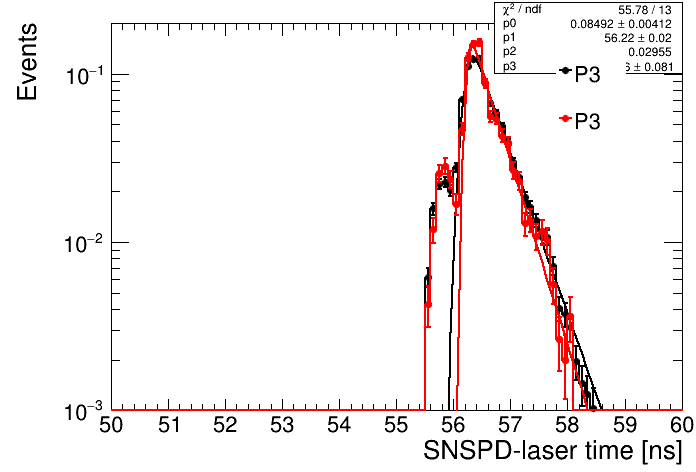

In [50]:
# plot DCR for different channels in one canvas


c = rt.TCanvas("c2","c2",200,10,700,500);
h = {}
gaus = {}
leg = rt.TLegend(0.8,0.7,0.9,0.9)
leg.SetTextSize(0.05)
leg.SetTextFont(42)
leg.SetBorderSize(0)
leg.SetEntrySeparation(0.01)
leg.SetFillColor(0)
# if not "0p2" in temp:continue

for i, k in enumerate(tree.keys()):
#     if not i == 0:continue
    if not "0.5" in k:continue
    if not "P3" in k:continue
#     if  "0p155" in k:continue
    if not "5_B2_P3_0p18" in k:continue
    if not ("0p14" in k or "0p16" in k or "0p18" in k or "0p2" in k ):continue


    cond = (time[k][:,0]>-999) 

#     h[k] = create_TH1D((time_nofit[k][:,1]-time_nofit[k][:,0]), axis_title = ['SNSPD-laser time [ns]','Events'], binning = [100,54,60])
#     h[k] = create_TH1D((time[k][:,1]-time[k][:,0]), axis_title = ['SNSPD-laser time [ns]','Events'], binning = [100,54,60])
#     h[k] = create_TH1D((time_50mV[k][:,1]), axis_title = ['SNSPD-laser time [ns]','Events'], binning = [100,50,60])
#     h[k] = create_TH1D((amplitude[k][:,1]), axis_title = ['amplitude [V]','Events'], binning = [100,0,0.3])
#     h[k] = create_TH1D((amplitude[k][:,0]), axis_title = ['laser amplitude [V]','Events'], binning = [100,0,5])
    trg = create_TH1D((time_50mV[k][:,0]), axis_title = ['laser time [ns]','Events'], binning = [200,-100,100])
    
    print(k, trg.GetBinCenter(trg.GetMaximumBin()), trg.GetBinContent(trg.GetMaximumBin())/trg.Integral())
    if trg.GetBinContent(trg.GetMaximumBin())/trg.Integral()<0.4:
        print(k, "too much dark count")
        h[k].Scale(0)
        continue

    
    median = np.median(time_50mV[k][:,1]-time_50mV[k][:,0][cond])
    bins = [150,median-10,median+10]
    bins = [100,50,60]
    cond = time[k][:,0]>-999
    h[k] = create_TH1D((time_50mV[k][:,1]-time_50mV[k][:,0])[cond], axis_title = ['SNSPD-laser time [ns]','Events'], binning = bins)

    

    
for i, k in enumerate(h.keys()):
    emg = EMG()
    h[k].Scale(1./h[k].Integral())
    fit, fit_err, gaus[k] = fit_emg(h[k], emg)
#     fit, fit_err, gaus[k] = fit_gaus(h[k])

    
hist_max = 0
for i, k in enumerate(h.keys()):
    

    h[k].SetLineColor(std_color_list[i])
    h[k].SetMarkerColor(std_color_list[i])
    h[k].SetMarkerSize(0.9)
    h[k].SetMarkerStyle(8)
    h[k].SetTitle('')

    hist_max = max(hist_max, h[k].GetBinContent(h[k].GetMaximumBin()))
    h[k].SetMaximum(0.2)
    h[k].SetMinimum(0.001)
    leg.AddEntry(h[k],k.split("_")[2])

    h[k].Draw('hist E1 same')
    gaus[k].SetLineWidth(2)
    gaus[k].SetLineColor(std_color_list[i])
    gaus[k].Draw("same")


leg.Draw()
c.SetLogy()


c.Draw()
